# Visium HD tutorial

For this tutorial, we use the [mouse small intestine public dataset](https://www.10xgenomics.com/datasets/visium-hd-cytassist-gene-expression-libraries-of-mouse-intestine) from 10X Genomics.

In [1]:
import sopa

In [2]:
sdata = sopa.io.visium_hd("/Users/quentinblampey/data/visium_hd/Visium_HD_Mouse_Small_Intestine")
sdata

/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/sopa-hDHgkEug-py3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


SpatialData object
├── Images
│     ├── 'Visium_HD_Mouse_Small_Intestine_full_image': DataTree[cyx] (3, 21943, 23618), (3, 10971, 11809), (3, 5485, 5904), (3, 2742, 2952), (3, 1371, 1476)
│     ├── 'Visium_HD_Mouse_Small_Intestine_hires_image': DataArray[cyx] (3, 5575, 6000)
│     └── 'Visium_HD_Mouse_Small_Intestine_lowres_image': DataArray[cyx] (3, 558, 600)
├── Shapes
│     └── 'Visium_HD_Mouse_Small_Intestine_square_002um': GeoDataFrame shape: (5479660, 2) (2D shapes)
└── Tables
      └── 'square_002um': AnnData (5479660, 19059)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        Visium_HD_Mouse_Small_Intestine_hires_image (Images), Visium_HD_Mouse_Small_Intestine_square_002um (Shapes)
    ▸ 'downscaled_lowres', with elements:
        Visium_HD_Mouse_Small_Intestine_lowres_image (Images), Visium_HD_Mouse_Small_Intestine_square_002um (Shapes)
    ▸ 'global', with elements:
        Visium_HD_Mouse_Small_Intestine_full_image (Images), Visium_HD_Mouse_Small_Intest

First, we can segment the tissue (i.e., create the contour of the tissue) based on the H&E image.
It will prevent from segmenting cells on empty regions.

Here, `image_key` is the name of the "hires" image. The "full resolution" image is not necessary for tissue segmentation.

In [3]:
sopa.tissue_segmentation(sdata, image_key="Visium_HD_Mouse_Small_Intestine_hires_image")

True

We can see the contour of the tissue in red:

INFO     Using matplotlib                                                                                          


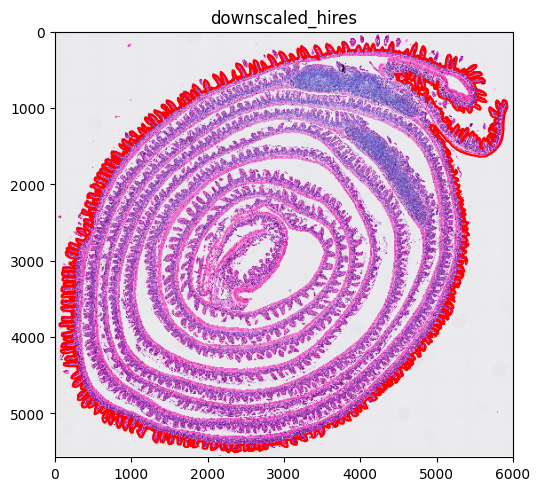

In [4]:
import spatialdata_plot

sdata.pl.render_images("Visium_HD_Mouse_Small_Intestine_hires_image").pl.render_shapes(
    "region_of_interest", outline=True, outline_color="r", fill_alpha=0
).pl.show("downscaled_hires")

Then, we create the patches for the cell segmentation. Now, we use the "full resolution" image, which is needed to have the best resolution.

In [6]:
image_key = "Visium_HD_Mouse_Small_Intestine_full_image"

sopa.make_image_patches(sdata, image_key=image_key)

/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/sopa-hDHgkEug-py3.9/lib/python3.9/site-packages/spatialdata/_core/_elements.py:96: UserWarning: Key `sopa_patches` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
[INFO] (sopa.patches.patches) 116 patches were saved in sdata['sopa_patches']


In [7]:
channels = ["0"] # only the first channel of the H&E image is used for nuclei segmentation

method = sopa.segmentation.methods.cellpose_patch(diameter=15, channels=channels, flow_threshold=2, cellprob_threshold=-6)
segmentation = sopa.segmentation.StainingSegmentation(sdata, method, channels, min_area=50, image_key=image_key)

# The cellpose boundaries will be temporary saved here. You can choose a different path
cellpose_temp_dir = "tuto.zarr/.sopa_cache/cellpose_boundaries"

In [8]:
segmentation.write_patches_cells(cellpose_temp_dir)

In [8]:
cells = sopa.segmentation.StainingSegmentation.read_patches_cells(cellpose_temp_dir)
cells = sopa.segmentation.shapes.solve_conflicts(cells)

shapes_key = "cellpose_boundaries" # name of the key given to the cells in sdata.shapes

sopa.segmentation.StainingSegmentation.add_shapes(sdata, cells, image_key, shapes_key)

[INFO] (sopa.segmentation.stainings) Found 654620 total cells
Resolving conflicts: 100%|██████████| 74808/74808 [00:44<00:00, 1676.41it/s]
[INFO] (sopa.segmentation.stainings) Added 637020 cell boundaries in sdata['cellpose_boundaries']


Now, we need to aggregate the bins into the cells. For that, we need to specify `bins_key`, which is the name of the table containing the gene expression vectors for each bin.

In [9]:
aggregator = sopa.segmentation.Aggregator(
    sdata,
    image_key="Visium_HD_Mouse_Small_Intestine_full_image",
    shapes_key="cellpose_boundaries",
    bins_key="square_002um",
)
aggregator.compute_table(average_intensities=False)

/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/sopa-hDHgkEug-py3.9/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/sopa-hDHgkEug-py3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/sopa-hDHgkEug-py3.9/lib/python3.9/site-packages/spatialdata/_core/_elements.py:96: UserWarning: Key `cellpose_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


Now, we have an AnnData object with the gene expression **per cell**.

In [12]:
adata = sdata["table"]
adata

AnnData object with n_obs × n_vars = 637020 × 19059
    obs: 'region', 'slide', 'cell_id', 'area'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'sopa_attrs', 'spatialdata_attrs'
    obsm: 'spatial'

For instance, we can now use Scanpy to plot gene expression. Here, **cells** are shown, not bins.

In [13]:
import scanpy as sc

In [20]:
# basic preprocessing
sc.pp.filter_genes(adata, min_cells=100)
sc.pp.filter_cells(adata, min_counts=100)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/sopa-hDHgkEug-py3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


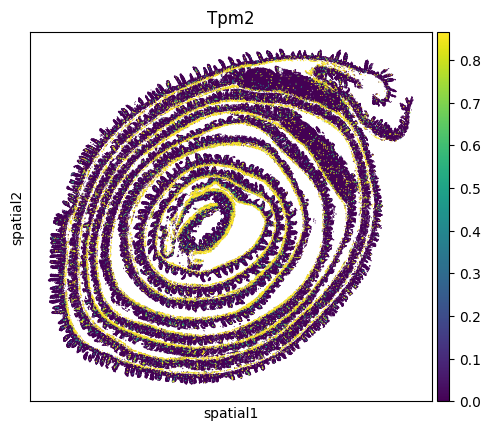

In [21]:
sc.pl.spatial(adata, color="Tpm2", spot_size=60, vmax="p95")